# Scores
* In this notebook, we create the final scores by using the scores computed on Google Colab

## BERT-F1 Considerations
* BERT-F1 had 3 different cases which we mention here
* BERT-F1 without rescaling with baseline (default)
* BERT-F1 with rescaling with baseline (option, recommended for more interpretable scores)
* BERT-F1 with different model type for English (default is `roberta-large`, we used `bert-base-multilingual-cased`)

In [1]:
from scripts.presentation import Presenter
p1 = Presenter(results_folder='bertscore_results',
              metrics=['BLEU', 'BERT-F1'])
p2 = Presenter(results_folder='bertscore_no_rescale_results',
              metrics=['BLEU', 'BERT-F1'])

bertscore_results
Datasets: ['ep'] : ['ep']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : BERT-F1
Pearson correlation: 0.07 (p = 4.6e-01)
Spearman correlation: 0.30 (p = 1.3e-03)



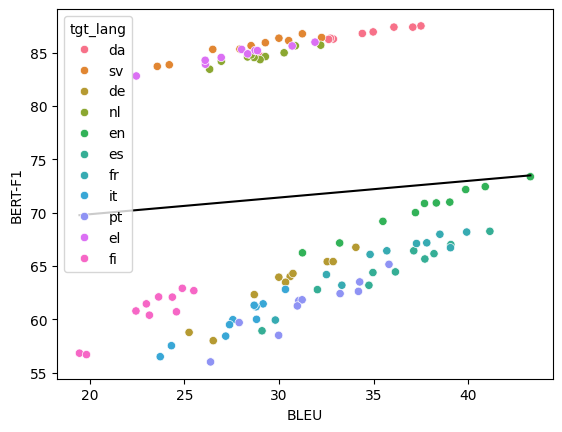

bertscore_no_rescale_results
Datasets: ['ep'] : ['ep']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : BERT-F1
Pearson correlation: 0.72 (p = 3.8e-19)
Spearman correlation: 0.92 (p = 1.0e-45)



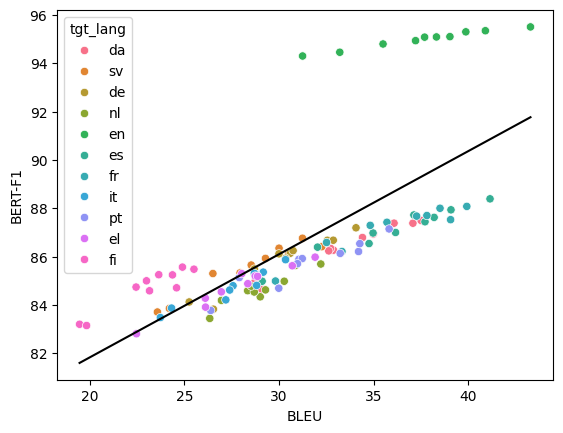

In [2]:
for p in [p1, p2]:
    print(p.store)
    for d in ['ep']:
        for t in ['deepl']:
            config1 = {
                'datasets': [d],
                'translators': [t],
                'src_lang': None,
                'tgt_lang': None,
                'metric': 'BLEU'

            }
            config2 = {
                'datasets': [d],
                'translators': [t],
                'src_lang': None,
                'tgt_lang': None,
                'metric': 'BERT-F1'
            }
            p.show_correlations(config1, config2)
            out, model = p.linear_regression(
                config1, config2, 'BLEU', 'BERT-F1', color_by='tgt_lang')


* If we apply rescaling on everything, we actually apply rescaling only on: `de`, `en`, `es`, `fi`, `fr`, `it`, `pt`
    * This is why linear regression shows a big gap between those two target languages; the one that were rescaled are lower
    * `el`, `nl`, `da` and `sv` were not rescaled
* If we do not apply rescaling, we use model `roberta-large` for English and `bert-base-multilingual-cased` for all other languages
    * This is why linear regression shows a gap between English and other target languages, a different model was used.

* Thus, we decide to use `bert-base-multilingual-cased` for all languages without applying rescaling


# Scores
* BLEU and chrF were computed twice
* COMET and BERT-F1 were computed in different Jupyter Notebooks on Google Colab
    *  [COMET scores & notebook](https://drive.google.com/drive/folders/1V321016DBvO_WaaH2FNFsoaO5VdQvKci?usp=sharing)
    * [BERT-F1 scores & notebook](https://drive.google.com/drive/folders/1ooR-AQK_B7kozybE7JRwM6U-dzK48ceS?usp=sharing)
    * [BERT-F1 scores without rescaling & notebook](https://drive.google.com/drive/folders/1v-nFv23XG8jWWKZuDu0-sYPJyaKXk67l?usp=sharing)
    * [BERT-F1 scores without rescaling and different model (English only) & notebook](https://drive.google.com/drive/folders/11-SZ3FXaPejWqbsJQSZOOV7FWR8Yqcrz?usp=sharing)
* By asserting if BLEU and chrF are equivalent, we can confirm that both COMET and BERT-F1 were indeed computed on the same final_triplet files

In [3]:
import os
import pandas as pd

bertscore_files = os.listdir('bertscore_no_rescale_results')
comet_files = os.listdir('comet_results')

# ChatGPT Aided for pandas
dfs = {}
for f1 in bertscore_files:
    for f2 in comet_files:
        if f1 == f2:
            df1 = pd.read_csv(os.path.join('bertscore_no_rescale_results', f1)).sort_values(
                by='Label').reset_index(drop=True)
            df2 = pd.read_csv(os.path.join('comet_results', f2)).sort_values(
                by='Label').reset_index(drop=True)
            df3 = pd.read_csv(os.path.join('bertscore_no_rescale_en_results', f1)).sort_values(
                by='Label').reset_index(drop=True)

            # Overwrite df1 rows where Label ends with '-en' using df3
            mask = df1['Label'].str.endswith('-en')
            df1_non_en = df1[~mask]
            df1_en = df3[df3['Label'].isin(df1[mask]['Label'])]

            # Combine the overwritten and original parts
            df1 = pd.concat([df1_non_en, df1_en]).sort_values(
                by='Label').reset_index(drop=True)

            assert df1['Label'].equals(df2['Label'])
            assert df1['BLEU'].equals(df2['BLEU'])
            assert df1['chrF'].equals(df2['chrF'])

            df = pd.merge(df1, df2, on=['Label', 'BLEU', 'chrF'])
            dfs[f1.replace('.csv', '')] = df

In [4]:
import os
os.makedirs('final_results', exist_ok=True)

for k in dfs:
    df = dfs[k]
    df.to_csv(os.path.join('final_results', f'{k}.csv'), index=False)